In [1]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities.visualization import Visualizer
import keras
from keras import Model
from keras import optimizers
from keras import metrics
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer
from utilities.data_reader import DataReader
from utilities.mapping import Mapper
from utilities.representatives_generator import RepresentativesGenerator
from utilities.output_signatures import OutputSignature
from distance.EuclideanDistance import EuclideanDistance

# Hyperparameters

In [2]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 280
validation_triplets = 40
training_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training"
validation_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation"

# Creating training dataset from generator 

In [3]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                method="triplet_loss")
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


# Creating validation dataset from generator

In [4]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  max_iterations=validation_triplets,
                                                  method="triplet_loss")
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(100, 100, 3)


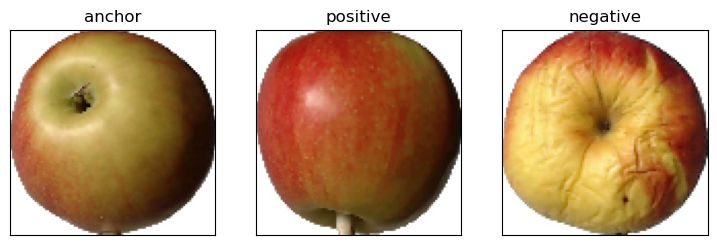

In [5]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

(100, 100, 3)


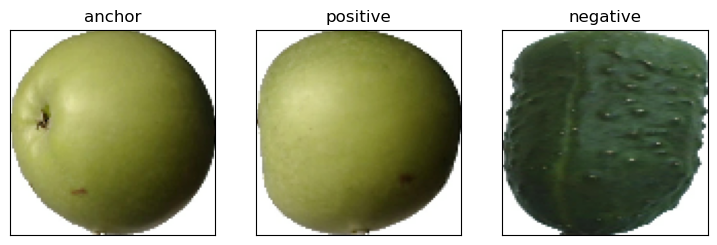

In [6]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

# Creating siamese model

In [7]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [8]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Compilation of our model and summary

In [9]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001))
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ ?                      │       230,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,902 (901.96 KB)

 Trainable params: 199,920 (780.94 KB)

 Non-trainable params: 30,982 (121.02 KB)

# Training 

In [10]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset)

Epoch 1/10
     18/Unknown 5s 132ms/step - loss: 0.2052

C:\Users\matim\Apps\Anaconda3\envs\ml\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.2012 - val_loss: 0.1133
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0612 - val_loss: 0.0614
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0607 - val_loss: 0.0245
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0568 - val_loss: 0.0144
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0565 - val_loss: 0.0705
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0266 - val_loss: 0.0339
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0242 - val_loss: 0.0090
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0541 - val_loss: 0.0472
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.0448 - val_loss: 0.0322
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.0555 - val_loss: 0.0248


In [11]:
class Representative:
    def __init__(self, label=None, image_path=None, image=None, embedding=None):
        self.label = label
        self.image_path = image_path
        self.image = image
        self.embedding = embedding
    

In [12]:
path = r".\data\products"
products_paths = DataReader.read_types_of_products(path)
products_dictionary = DataReader.generate_images_classes_dict(products_paths)
print(products_dictionary)

{'.\\data\\products\\Apple A': ['.\\data\\products\\Apple A\\Apple 51.png'], '.\\data\\products\\Apple B': ['.\\data\\products\\Apple B\\193red applee02611193.png'], '.\\data\\products\\Apple C': ['.\\data\\products\\Apple C\\Apple Ce05161.png'], '.\\data\\products\\Apple D': ['.\\data\\products\\Apple D\\Apple De05481.png'], '.\\data\\products\\Apple E': ['.\\data\\products\\Apple E\\Apple E65.png'], '.\\data\\products\\Apple F': ['.\\data\\products\\Apple F\\Apple F _0_5344.png'], '.\\data\\products\\Banana': ['.\\data\\products\\Banana\\Banana019.png'], '.\\data\\products\\Carambola': ['.\\data\\products\\Carambola\\Carambola 0051.png'], '.\\data\\products\\guava A': ['.\\data\\products\\guava A\\cene04261.png'], '.\\data\\products\\guava B': ['.\\data\\products\\guava B\\Guava27.png'], '.\\data\\products\\kiwi A': ['.\\data\\products\\kiwi A\\Kiwi A0056.png'], '.\\data\\products\\Kiwi B': ['.\\data\\products\\Kiwi B\\Kiwi B00255.png'], '.\\data\\products\\Kiwi C': ['.\\data\\produc

In [13]:
# path = r".\data\products"
# generator = RepresentativesGenerator(dataset_path=path)
# representatives_dataset = (tf.data.Dataset.from_generator(generator.get_next_element,
#                                                          output_signature=OutputSignature.representatives)
#                                                          .map(lambda label, image: 
#                                                               Mapper(image_size)(label, image, method="representatives")).batch(1))
# print(representatives_dataset)

In [14]:
representatives = []
mapper = Mapper(image_size)
for label, product in products_dictionary.items():
    rep = Representative()
    rep.label, rep.image = mapper.map(label, product[0])
    rep.image_path = product[0]
    representatives.append(rep)
print(representatives[0].label, representatives[0].image_path, representatives[0].image)

.\data\products\Apple A .\data\products\Apple A\Apple 51.png tf.Tensor(
[[[0.2255961  0.29038826 0.2899569 ]
  [0.23835295 0.26623532 0.24662746]
  [0.23574512 0.2679804  0.28039217]
  ...
  [0.10958823 0.16362745 0.12070587]
  [0.09183137 0.14673333 0.09997647]
  [0.0716078  0.12650976 0.09121565]]

 [[0.22214903 0.32669413 0.42723927]
  [0.44647062 0.4560079  0.45992947]
  [0.5314902  0.58705884 0.6034118 ]
  ...
  [0.02890213 0.07466684 0.0328237 ]
  [0.00893324 0.05132143 0.01156069]
  [0.         0.02067842 0.        ]]

 [[0.16617647 0.2802157  0.4179216 ]
  [0.43699992 0.45699996 0.4414509 ]
  [0.53450984 0.58833337 0.5960785 ]
  ...
  [0.         0.01960784 0.        ]
  [0.         0.01568628 0.        ]
  [0.         0.01176471 0.        ]]

 ...

 [[0.1254902  0.0509804  0.02882368]
  [0.1322745  0.06521576 0.03952953]
  [0.15490197 0.07039221 0.04156854]
  ...
  [0.13333334 0.20431365 0.2060784 ]
  [0.15745036 0.20843077 0.2162739 ]
  [0.17297971 0.2218425  0.22105813]]

 [

In [15]:
for r in representatives:
    r.image = tf.reshape(r.image, shape=(1,100,100,3))
    
print(representatives[0].image)

tf.Tensor(
[[[[0.2255961  0.29038826 0.2899569 ]
   [0.23835295 0.26623532 0.24662746]
   [0.23574512 0.2679804  0.28039217]
   ...
   [0.10958823 0.16362745 0.12070587]
   [0.09183137 0.14673333 0.09997647]
   [0.0716078  0.12650976 0.09121565]]

  [[0.22214903 0.32669413 0.42723927]
   [0.44647062 0.4560079  0.45992947]
   [0.5314902  0.58705884 0.6034118 ]
   ...
   [0.02890213 0.07466684 0.0328237 ]
   [0.00893324 0.05132143 0.01156069]
   [0.         0.02067842 0.        ]]

  [[0.16617647 0.2802157  0.4179216 ]
   [0.43699992 0.45699996 0.4414509 ]
   [0.53450984 0.58833337 0.5960785 ]
   ...
   [0.         0.01960784 0.        ]
   [0.         0.01568628 0.        ]
   [0.         0.01176471 0.        ]]

  ...

  [[0.1254902  0.0509804  0.02882368]
   [0.1322745  0.06521576 0.03952953]
   [0.15490197 0.07039221 0.04156854]
   ...
   [0.13333334 0.20431365 0.2060784 ]
   [0.15745036 0.20843077 0.2162739 ]
   [0.17297971 0.2218425  0.22105813]]

  [[0.12811771 0.06537261 0.041843

In [16]:
for r in representatives:
    r.embedding = np.asarray(embedding_model(r.image)).astype('float32')
    print(r.embedding)

[[-0.9739509  -0.60996664 -0.96970356 -0.07865213 -0.01476325  0.85470086
   0.9141874  -0.22253788  0.27528375 -0.3105295 ]]
[[-0.9819956  -0.9340517  -0.79554856  0.03064357 -0.30592972  0.4700968
   0.97091866  0.4593271  -0.828338   -0.62425226]]
[[-0.99216306 -0.88241136 -0.9277504  -0.0942039  -0.3054186   0.77522326
   0.9594327   0.2049982  -0.37369314 -0.34154534]]
[[-0.97996503 -0.9298414  -0.55572283 -0.01883062 -0.6664352   0.4199304
   0.97607386  0.3585439  -0.899493   -0.16476293]]
[[-0.96355164 -0.94829565 -0.5258337   0.28850213 -0.46505153  0.44679677
   0.94323766  0.5559494  -0.95092386 -0.5181313 ]]
[[-0.9831223  -0.85135055 -0.7345225  -0.02836432 -0.586371    0.79597676
   0.9681337  -0.17605917 -0.47135347  0.19194698]]
[[-9.8917598e-01 -3.8297799e-01 -8.8446802e-01 -7.4190986e-01
  -6.4745116e-01  9.0972477e-01  9.4881564e-01 -8.7778323e-04
   3.0875474e-01  6.6909927e-01]]
[[-0.9888029  -0.8550793  -0.7024443  -0.583033   -0.7155876   0.7667122
   0.9434841   

# Visualizing the next triplet

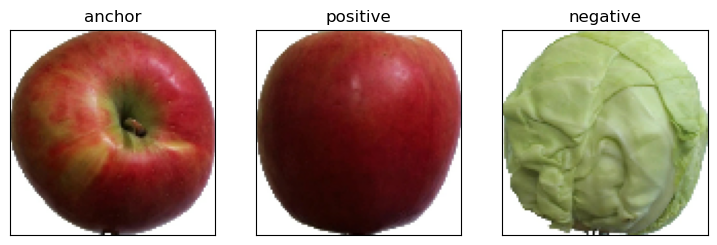

In [17]:
sample = next(iter(training_dataset))
anchor_img = np.asarray(sample[0][0]).astype('float32')
positive_img = np.asarray(sample[1][0]).astype('float32')
negative_img = np.asarray(sample[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})

In [18]:
def closest_representative(embedding, representatives):
    min_distance = float('inf')
    closest_rep = None
    for rep in representatives:
        distance = np.sqrt(np.sum(np.square(embedding - rep.embedding)))
        if  distance < min_distance: 
            min_distance = distance
            closest_rep = rep
    return closest_rep


In [19]:
anchor = sample[0]
anchor_embedding = embedding_model(anchor)
representatives_copy = representatives.copy()
top_3 = []
closest = closest_representative(anchor_embedding, representatives_copy)
print(closest.label)
top_3.append(closest)
representatives_copy.remove(closest)
closest = closest_representative(anchor_embedding, representatives_copy)
print(closest.label)
top_3.append(closest)
representatives_copy.remove(closest)
closest = closest_representative(anchor_embedding, representatives_copy)
print(closest.label)
top_3.append(closest)
representatives_copy.remove(closest)


.\data\products\Orange
.\data\products\Apple C
.\data\products\Peach
